In [98]:
%cd /home/ubuntu

/home/ubuntu


## Downloading data from S3

In [99]:
!mkdir -p data
!curl "https://data-science-v2.s3.amazonaws.com/all_nll.csv.gz" -o "data/all_nll.csv.gz"
!curl "https://data-science-v2.s3.amazonaws.com/lossess.csv" -o "data/lossess.csv"
!gunzip "data/all_nll.csv.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1212M  100 1212M    0     0  95.2M      0  0:00:12  0:00:12 --:--:-- 95.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8351  100  8351    0     0   153k      0 --:--:-- --:--:-- --:--:--  153k


# Monitoring Time Series

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display, TextDisplayObject, Markdown, Latex


In [4]:
# Flags
burnin = 2

In [144]:
# Data
df_nll = pd.read_csv('data/all_nll.csv')
df_loss = pd.read_csv("data/lossess.csv")

## Lossess

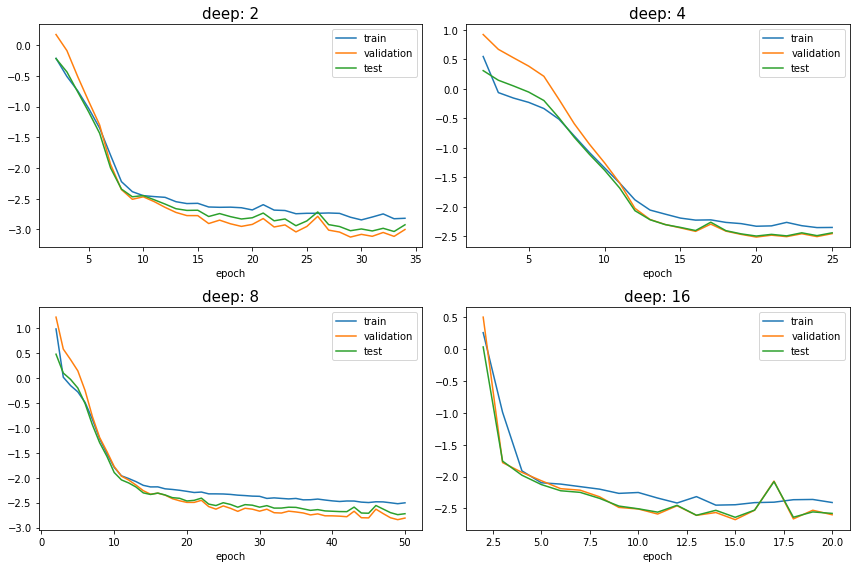

In [116]:
grouped = df_loss.loc[df_loss['epoch'] > 1].groupby("deep")
dims = (2,2)
fig, axs = plt.subplots(*dims, figsize=(12,8))
for (deep,df), ax in zip(grouped, axs.flatten()):
    df.plot(x='epoch', y=['train','validation','test'], ax=ax, title=f"deep: {deep}")
    ax.title.set_fontsize(15)
plt.tight_layout()

## NLL 

In [147]:
output = ""
tablespacing=10
tabel_styles = {
    'selector': 'caption',
    'props': [
        ('font-size', '20px')
    ]
}
nll = [c for c in df_nll.columns if 'nll' in c]
nll_df_ = df_nll.groupby(['nans', 'deep', 'miss'])[nll].mean().mean(axis=1).reset_index(drop=False)
for method, df in nll_df_.groupby('miss'):
    output += df.pivot_table(values=0, index='nans', columns='deep').style.set_table_attributes("style='display:inline'")\
        .set_caption(method).set_table_styles([tabel_styles])._repr_html_()
    output += tablespacing * "\xa0"
display(HTML(output))


deep,2,4,8,16
nans,,,,
5,-2.518932,-2.169222,-2.324952,-2.261265
10,-2.496050,-2.151268,-2.300165,-2.248365
15,-2.441728,-2.110451,-2.254963,-2.218176
20,-2.593584,-2.223778,-2.382331,-2.306832
deep,2,4,8,16
nans,,,,
5,-2.508215,-2.163930,-2.323438,-2.260711
10,-2.485124,-2.143158,-2.301747,-2.246541
15,-2.430634,-2.098874,-2.258537,-2.214722


In [148]:
df_nll

,nans,idx,deep,miss,NetworkOut,NetworkIn,CPUUtilization,NetworkOut_mean,NetworkOut_std,NetworkOut_nll,NetworkIn_mean,NetworkIn_std,NetworkIn_nll,CPUUtilization_mean,CPUUtilization_std,CPUUtilization_nll
0,20,6772,2,distribution,NaN,4178594.0,3.166667,1.045411e+06,4.264068e+06,NaN,1.149850e+07,2.527675e+07,NaN,3.635208,5.423862,NaN
1,20,6772,2,distribution,NaN,NaN,2.000000,5.728110e+05,9.023216e+05,NaN,5.451616e+06,6.901009e+06,NaN,3.088922,1.840179,-1.811720
2,20,6772,2,distribution,27370.0,26043.0,0.833333,4.974184e+05,7.343054e+05,-3.108326,5.023849e+06,6.569678e+06,-2.116112,2.938778,1.857912,-0.858498
3,20,6772,2,distribution,NaN,NaN,1.525424,3.092421e+05,4.080826e+05,NaN,3.740767e+06,4.692357e+06,NaN,2.392862,1.447329,-2.282962
4,20,6772,2,distribution,248060.0,1861816.0,3.114754,2.835796e+05,3.657459e+05,-4.902514,3.401722e+06,4.364558e+06,-3.388225,2.248755,1.391543,-2.333485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13893115,5,6389,16,sampling,133721.0,1212146.0,1.475410,6.466711e+05,5.927774e+05,-3.197505,7.954927e+06,8.077292e+06,-1.584792,3.292226,2.239708,-1.110903
13893116,5,6389,16,sampling,108329.0,1055649.0,1.833333,6.231131e+05,5.671101e+05,-3.210863,7.600346e+06,7.725126e+06,-1.653070,3.197644,2.148860,-1.448640
13893117,5,6389,16,sampling,113068.0,1055704.0,1.355932,5.993546e+05,5.405169e+05,-3.321489,7.281513e+06,7.382972e+06,-1.750317,3.109310,2.057793,-1.212328
13893118,5,6389,16,sampling,229138.0,3076816.0,2.131148,5.748792e+05,5.135970e+05,-3.779876,6.964155e+06,7.037651e+06,-2.252108,3.021362,1.965889,-1.824666


In [149]:
df = df_nll.loc[df_nll['idx'] == 6772]

0                NaN
1          -1.811720
2          -2.027645
3          -2.282962
4          -3.541408
              ...   
13643272   -0.527039
13643273    4.072207
13643274   -3.482352
13643275   -2.155090
13643276   -0.952449
Length: 9648, dtype: float64